## Arbitrary Style Transfer using Adaptive Instance Normalization Approach
### Training code and style transfer demo
**Training set image requirements**
1. 1:1 Content and style images 
2. resized to have the smallest dimension 512px
3. jpegs

*If needed, python code to resize images is in the file src/image_processor.py*

Authors of the approach used approximately 80.000 images to train their model. Due to a limited resources this model was trained on 40.000 images (20k content, 20k style)

In [1]:
# DATASET AND DATALOADER

from torch.utils.data import Dataset, DataLoader

class StyleContentDataset(Dataset):
    """
    Dataset for loading content and style images for style transfer training.
    It needs to get preliminarily prepared files. Files must have smaller dimension of 512 pixels.
    Use prepare_images.py to resize raw images
    """
    def __init__(self, content_dir, style_dir, image_size=224):
        self.content_dir = content_dir
        self.style_dir = style_dir
        self.image_size = image_size

        # Load content image paths
        self.content_paths = [
            os.path.join(content_dir, f)
            for f in os.listdir(content_dir)
            if f.lower().endswith('.jpg')
        ]

        # Load style image paths
        self.style_paths = [
            os.path.join(style_dir, f)
            for f in os.listdir(style_dir)
            if f.lower().endswith('.jpg')
        ]

        # Create shuffled indices for both content and style
        self.reshuffle()

        # Define transforms
        self.transform = transforms.Compose([
            transforms.RandomCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def reshuffle(self):
        """Reshuffle both content and style indices"""
        self.content_indices = torch.randperm(len(self.content_paths))
        self.style_indices = torch.randperm(len(self.style_paths))

    def __len__(self):
        # Return minimum length to ensure paired iteration
        return min(len(self.content_paths), len(self.style_paths))

    def __getitem__(self, idx):
        # Use modulo to wrap around indices if needed
        content_idx = self.content_indices[idx % len(self.content_paths)]
        style_idx = self.style_indices[idx % len(self.style_paths)]

        content_path = self.content_paths[content_idx]
        style_path = self.style_paths[style_idx]

        # Load and transform images
        content_img = Image.open(content_path).convert('RGB')
        style_img = Image.open(style_path).convert('RGB')

        content_img = self.transform(content_img)
        style_img = self.transform(style_img)

        # Verify numerical validity
        assert not torch.isnan(content_img).any(), f"NaN in content image: {content_path}"
        assert not torch.isnan(style_img).any(), f"NaN in style image: {style_path}"

        return content_img, style_img

def create_dataloaders(content_dir, style_dir, batch_size):
    dataset = StyleContentDataset(content_dir, style_dir)

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # for MPS compatibility
        pin_memory=True,
        persistent_workers=False,  # for MPS compatibility
        drop_last=True
    )



In [2]:
# VGG19 BASED ENCODER

import torch.nn as nn
from torchvision.models import vgg19, VGG19_Weights


def replace_padding(model):
    """Replace all ZeroPad2d with ReflectionPad2d in the model"""
    modules = list(model.named_children())

    for name, module in modules:
        if len(list(module.children())) > 0:
            replace_padding(module)

        if isinstance(module, nn.Conv2d):
            padding = module.padding
            if padding[0] != 0:
                refl_pad = nn.ReflectionPad2d(padding[0])
                conv = nn.Conv2d(
                    module.in_channels,
                    module.out_channels,
                    module.kernel_size[0],
                    module.stride[0],
                    padding=0,
                    bias=(module.bias is not None)
                )

                # Copy the weights and bias
                conv.weight.data = module.weight.data
                if module.bias is not None:
                    conv.bias.data = module.bias.data

                # Get the index of the current module
                for i, (curr_name, curr_module) in enumerate(model._modules.items()):
                    if curr_module == module:
                        # Create new OrderedDict with updated structure
                        from collections import OrderedDict
                        new_modules = OrderedDict()

                        # Copy modules up to this point
                        for j, (n, m) in enumerate(model._modules.items()):
                            if j == i:
                                # Insert our new modules
                                new_name = f"{name}_pad"
                                new_modules[new_name] = refl_pad
                                new_modules[name] = conv
                            else:
                                new_modules[n] = m

                        # Replace the modules in the model
                        model._modules = new_modules
                        break

class VGGEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg19(weights=VGG19_Weights.DEFAULT).features
        replace_padding(vgg)

        # slices are adjusted because of the reflection padding added
        self.slice1 = vgg[: 3]
        self.slice2 = vgg[3: 10]
        self.slice3 = vgg[10:17]
        self.slice4 = vgg[17: 30]

        for p in self.parameters():
            p.requires_grad = False

    def forward(self, image, output_style_features=False):
        s1 = self.slice1(image)
        s2 = self.slice2(s1)
        s3 = self.slice3(s2)
        s4 = self.slice4(s3)

        if output_style_features:
            return s1, s2, s3, s4
        else:
            return s4


In [3]:
# CUSTOM DECODER, MIMICkING VGG19 BASED ENCODER

import torch.nn as nn


class Decoder(nn.Module):
    """
    Decoder network that mirrors VGG-19 encoder structure (up to relu4_1).
    """

    def __init__(self):
        super().__init__()

        # Initialize decoder layers to mirror VGG encoder
        # All conv layers have corresponding reflection padding

        # Starting from relu4_1 features (512 channels)
        self.decoder = nn.Sequential(
            # Block 4 - Corresponding to VGG conv4_1
            nn.ReflectionPad2d(1),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),

            # Upsample 1 - Corresponding to VGG maxpool3
            nn.Upsample(scale_factor=2, mode='nearest'),

            # Block 3 - Corresponding to VGG conv3_4, conv3_3, conv3_2, conv3_1
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),

            # Upsample 2 - Corresponding to VGG maxpool2
            nn.Upsample(scale_factor=2, mode='nearest'),

            # Block 2 - Corresponding to VGG conv2_2, conv2_1
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),

            # Upsample 2 - Corresponding to VGG maxpool2
            nn.Upsample(scale_factor=2, mode='nearest'),

            # Block 1 - Corresponding to VGG conv1_2, conv1_1
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=0)
        )

    def forward(self, x):
        return self.decoder(x)


In [4]:
# ADAPTIVE INSTANCE NORMALIZATION (ADAIN)

import torch.nn as nn

class AdaIN(nn.Module):
    """Adaptive Instance Normalization"""

    def __init__(self):
        super().__init__()

    def forward(self, content, style):
        # Compute mean and std for both features
        content_mean, content_std = self.calc_stats(content)
        style_mean, style_std = self.calc_stats(style)

        # Normalize content features
        normalized = (content - content_mean) / content_std

        # Denormalize with style statistics
        return normalized * style_std + style_mean

    def calc_stats(self, x):
        """Calculate channel-wise mean and standard deviation"""
        b, c = x.shape[:2]
        x_flat = x.view(b, c, -1)
        mean = x_flat.mean(dim=2).view(b, c, 1, 1)
        std = x_flat.std(dim=2).view(b, c, 1, 1) + 1e-8
        return mean, std


In [5]:
# MODEL

import torch.nn as nn


class Model(nn.Module):
    """
    AdaIN-based Style Transfer Model
    Architecture:
    - Pretrained VGG-19 Encoder (up to conv4_1) with reflection padding
    - Adaptive Instance Normalization (AdaIN) layer
    - Trainable Decoder
    """

    def __init__(self):
        super().__init__()

        # Load pretrained VGG-19 and create encoder
        self.encoder = VGGEncoder()

        # AdaIN layer (stateless, no trainable parameters)
        self.adain = AdaIN()

        # Trainable decoder
        self.decoder = Decoder()

    def forward(self, content, style, alpha=1.0):
        # Extract features
        content_feat = self.encoder(content, output_style_features=False)
        style_feat = self.encoder(style, output_style_features=False)

        # Apply AdaIN
        adain_feat = self.adain(content_feat, style_feat)

        # Interpolate AdaIN output with content features
        t = alpha * adain_feat + (1 - alpha) * content_feat

        # Decode to image space
        output = self.decoder(t)

        # Return all three needed values
        return output, t


In [6]:
# LOSS CALCULATIONS

import torch.nn as nn
import torch.nn.functional as F

class StyleTransferLoss(nn.Module):
    def __init__(self, style_coeff):
        super().__init__()
        self.vgg = VGGEncoder()
        self.style_coeff = style_coeff

    def calc_stats(self, x):
        b, c = x.size()[:2]
        x_flat = x.view(b, c, -1)
        mean = x_flat.mean(dim=2, keepdim=True).unsqueeze(-1)
        std = x_flat.std(dim=2, keepdim=True).unsqueeze(-1) + 1e-6
        return mean, std

    def forward(self, generated, adain, style_img):

        # Content eature extraction
        gen_content_features = self.vgg(generated, output_style_features=False)

        # Content loss - up to conv4_1
        content_loss = F.mse_loss(gen_content_features, adain)

        # Style feature extraction
        gen_style_features = self.vgg(generated, output_style_features=True)
        style_features = self.vgg(style_img, output_style_features=True)

        # Style loss (multi-layer statistics from relu1_1, relu2_1, relu3_1 and relu4_1)
        style_loss = 0
        for gen, style in zip(gen_style_features, style_features):
            gen_mean, gen_std = self.calc_stats(gen)
            style_mean, style_std = self.calc_stats(style)
            style_loss += F.mse_loss(gen_mean, style_mean) + F.mse_loss(gen_std, style_std)

        # Total loss with adjusted weights
        total_loss = content_loss + self.style_coeff * style_loss

        return total_loss, content_loss.detach(), style_loss.detach()

In [7]:
def get_device():
    if torch.backends.mps.is_available():
        device = "mps"
    elif torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"

    print(f"Using device: {device}")
    return torch.device(device)

In [8]:
# TRAINING PROCESS SUPPORT FUNCTIONS

from datetime import datetime
import json
import os
import time
import torch

def save_training_stats(stats, stats_file):
    """Save training statistics to JSON file"""

    # Convert tensor values to floats for JSON serialization
    serializable_stats = {}
    for key, value in stats.items():
        if isinstance(value, list) and len(value) > 0:
            # Convert any torch tensors to float
            serializable_stats[key] = [float(v) if torch.is_tensor(v) else v for v in value]
        else:
            serializable_stats[key] = value

    with open(stats_file, 'w') as f:
        json.dump(serializable_stats, f, indent=4)


def should_stop_training(stats, patience=5, min_improvement=0.0001, window_size=5, lookback_windows=10):
    """
    Determine if training should be stopped based on recent loss statistics.

    Args:
        stats: Dictionary containing training statistics including 'total_loss'
        patience: Number of recent windows to wait before stopping
        min_improvement: Minimum required improvement in loss between windows
        window_size: Size of each window for calculating average loss
        lookback_windows: Number of recent windows to consider for plateau detection

    Returns:
        bool: True if training should stop, False otherwise
        str: Reason for stopping if True, empty string otherwise
    """
    total_losses = stats['total_loss']

    # Need enough epochs for analysis
    if len(total_losses) < window_size * 2:
        return False, ""

    # Calculate average losses for consecutive windows
    windows = []
    for i in range(len(total_losses) - window_size + 1):
        window_avg = sum(total_losses[i:i + window_size]) / window_size
        windows.append(window_avg)

    # Only look at the most recent windows for plateau detection
    recent_windows = windows[-lookback_windows:] if len(windows) > lookback_windows else windows
    stagnant_count = 0

    # Compare consecutive recent windows
    for i in range(len(recent_windows) - 1):
        current_window = recent_windows[i]
        next_window = recent_windows[i + 1]

        # Calculate relative improvement
        improvement = (current_window - next_window) / current_window

        if improvement < min_improvement:
            stagnant_count += 1
        else:
            stagnant_count = 0  # Reset only for recent windows

        # Check if we've had too many stagnant windows recently
        if stagnant_count >= patience:
            return True, f"Training has plateaued for {patience} recent windows with improvement less than {min_improvement}"

    # Check if loss is increasing in recent windows
    if len(recent_windows) >= 2:
        recent_trend = (recent_windows[-1] - recent_windows[-2]) / recent_windows[-2]
        if recent_trend > 0.01:  # Loss increased by more than 1%
            return True, "Loss is increasing in recent windows, possible overfitting"

    return False, ""


In [9]:
# TRANSFER STYLE ROUTINE

import matplotlib.pyplot as plt
import time
import torch
from torchvision import transforms
from PIL import Image
import os

def transfer_style(
        model,
        content_path,
        style_path,
        device,
        alpha=1.0,
        output_path=None,
        show_plot=True
):
    """
    Performs style transfer and either display results in a plot, save to file, or both.

    Args:
        model: Style transfer model
        content_path: Path to content image
        style_path: Path to style image
        device: Device to run the model on
        alpha: Style interpolation weight
        output_path: If provided, save the output image to this path
        show_plot: If True, display the results in a plot

    Returns:
        PIL Image of the stylized result
    """
    content_img = Image.open(content_path).convert('RGB')
    style_img = Image.open(style_path).convert('RGB')

    output_img = transfer_style_img(model, content_img, style_img, device, alpha)

    # Save if path provided
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        output_img.save(output_path)

    # Show plot if requested
    if show_plot:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(content_img)
        plt.title('Content Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(style_img)
        plt.title('Style Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(output_img)
        plt.title('Generated Image')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

def transfer_style_img(
        model,
        content_img,
        style_img,
        device,
        alpha=1.0
):
    """
    Performs style transfer of provided images

    Args:
        model: Style transfer model
        content_img: content image
        style_img: style image
        device: Device to run the model on
        alpha: Style interpolation weight

    Returns:
        result image
    """

    # Set model to eval mode
    model.eval()

    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    content_tensor = transform(content_img).unsqueeze(0).to(device)
    style_tensor = transform(style_img).unsqueeze(0).to(device)

    # Inverse transform for visualization
    inverse_transform = transforms.Compose([
        transforms.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
        )
    ])

    # Generate styled image
    with torch.no_grad():
        output, _ = model(content_tensor, style_tensor, alpha=alpha)

    # Convert tensor to image
    def tensor_to_image(tensor):
        img = inverse_transform(tensor.squeeze().cpu())
        img = torch.clamp(img, 0, 1)
        return transforms.ToPILImage()(img)

    # Get output image
    output_img = tensor_to_image(output)

    return output_img

In [10]:

def train_model(
        content_dir,
        style_dir,
        save_dir,
        training_prefix,
        num_epochs,
        batch_size,
        base_lr,
        style_loss_coeff,
        log_interval
):
    device = get_device()

    train_loader = create_dataloaders(content_dir, style_dir, batch_size)
    loss_fn = StyleTransferLoss(style_coeff=style_loss_coeff).to(device)
    model = Model().to(device)

    # Setup logging
    stats_file = os.path.join(save_dir, f'{training_prefix}_training_stats.json')

    # Log training setup
    print(f"Starting training for {num_epochs} epochs, batch size: {batch_size}, style loss coeff: {style_loss_coeff}")
    print(f"Initial learning rate: {base_lr}")

    # Training monitor setup
    monitor = TrainingMonitor(
        content_path='test_data/brad_pitt.jpg',
        style_path='test_data/vg.jpg',
        save_dir=save_dir,
        prefix=training_prefix
    )

    optimizer = torch.optim.Adam(
        model.decoder.parameters(),
        lr=base_lr,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.8,
        patience=3,
        min_lr=1e-5,
        cooldown=1
    )

    # Training stats setup
    stats = {
        'epoch_times': [],
        'total_loss': [],
        'content_loss': [],
        'style_loss': [],
        'learning_rates': [],
        'start_time': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

    for epoch in range(num_epochs):

        epoch_start = time.time()
        model.train()

        running_loss = running_content = running_style = 0.0

        for batch_idx, (content, style) in enumerate(train_loader):
            content = content.to(device)
            style = style.to(device)

            # Regular forward pass
            generated, adain = model(content, style)

            total_loss, content_loss, style_loss = loss_fn(
                generated,
                adain,
                style
            )

            optimizer.zero_grad()
            total_loss.backward()

            optimizer.step()

            # Update statistics
            running_loss += total_loss.item()
            running_content += content_loss.item()
            running_style += style_loss.item()

            # Log progress
            if batch_idx % log_interval == 0:
                avg_loss = running_loss / (batch_idx + 1)
                avg_content = running_content / (batch_idx + 1)
                avg_style = running_style / (batch_idx + 1)

                print(f"Epoch {epoch + 1}/{num_epochs} | Batch {batch_idx}"
                           f" | Loss: {avg_loss:.4f} [C: {avg_content:.4f}, S: {avg_style:.4f}]")

            monitor.generate_sample(
                model=model,
                device=device,
                epoch=epoch,
                current_iteration=batch_idx
            )

        # Epoch statistics
        epoch_time = time.time() - epoch_start
        avg_loss = running_loss / len(train_loader)
        avg_content = running_content / len(train_loader)
        avg_style = running_style / len(train_loader)
        current_lr = optimizer.param_groups[0]['lr']

        scheduler.step(avg_loss)

        # Save checkpoint
        checkpoint_path = os.path.join(save_dir, f'{training_prefix}_checkpoint_epoch{epoch + 1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'encoder': model.encoder.state_dict(),
            'decoder': model.decoder.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'loss': avg_loss,
            'content_loss': avg_content,
            'style_loss': avg_style,
            'stats': stats  # Save current training stats
        }, checkpoint_path)
        print(f"Saved checkpoint to {checkpoint_path}")

        # Record stats
        stats['epoch_times'].append(epoch_time)
        stats['total_loss'].append(avg_loss)
        stats['content_loss'].append(avg_content)
        stats['style_loss'].append(avg_style)
        stats['learning_rates'].append(current_lr)

        save_training_stats(stats, stats_file)
        print(f"Training statistics saved to {stats_file}")

        # Log epoch summary
        print(f"Epoch {epoch + 1} completed in {epoch_time:.1f}s | "
                   f"Avg Loss: {stats['total_loss'][-1]:.4f} [C: {stats['content_loss'][-1]:.4f}, S: {stats['style_loss'][-1]:.4f}, LR: {current_lr:.6f}]")

        should_stop, reason = should_stop_training(stats)
        if should_stop:
            print(f"Early stopping triggered: {reason}")
            break

    print(f"Training completed. Final LR: {optimizer.param_groups[0]['lr']}")

    # Save final stats
    stats['end_time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    save_training_stats(stats, stats_file)
    print(f"Training statistics saved to {stats_file}")

    return model

class TrainingMonitor:
    def __init__(
            self,
            content_path,
            style_path,
            save_dir,
            prefix,
            interval_minutes: int = 30
    ):
        self.content_path = content_path
        self.style_path = style_path
        self.save_dir = os.path.join(save_dir, 'progress_samples')
        self.prefix = prefix
        self.interval_seconds = interval_minutes * 60
        self.last_sample_time = 0
        self.last_epoch = 0
        os.makedirs(self.save_dir, exist_ok=True)

    def should_generate_sample(self, epoch, iter) -> bool:
        """Check if enough time has passed to generate a new sample"""
        current_time = time.time()
        if current_time - self.last_sample_time >= self.interval_seconds or iter % 500 == 0 or epoch > self.last_epoch:
            self.last_sample_time = current_time
            self.last_epoch = epoch
            return True
        return False

    def generate_sample(self, model, device, epoch: int, current_iteration: int):
        """Generate and save a sample style transfer"""
        if not self.should_generate_sample(epoch, current_iteration):
            return

        # Generate filename with timestamp and iteration
        timestamp = datetime.now().strftime('%H%M')
        filename = f'{self.prefix}_sample_{timestamp}_iter_{epoch:02d}_{current_iteration:04d}.jpg'
        save_path = os.path.join(self.save_dir, filename)

        # Run transfer_style function
        transfer_style(
            model=model,
            content_path=self.content_path,
            style_path=self.style_path,
            device=device,
            output_path=save_path,
            show_plot=False  # Don't show plots during training
        )

        print(f"Generated progress sample: {filename}")

In [11]:
# RUN TRAINING HERE

from datetime import datetime
import random
import string
import os
import torch

num_epochs=20
batch_size=8
base_lr=1e-3
style_loss_coeff=1.0
checkpoints_dir = 'checkpoints'
content_dir='training_data/content'
style_dir='training_data/style'

timestamp = datetime.now().strftime('%m%d_%H%M')
prefix = ''.join(random.choices(string.ascii_lowercase, k=6))
training_prefix = f"{timestamp}_{prefix}"

os.makedirs(checkpoints_dir, exist_ok=True)

model = train_model(
    content_dir=content_dir,
    style_dir=style_dir,
    save_dir=checkpoints_dir,
    training_prefix=training_prefix,
    num_epochs=num_epochs,
    batch_size=batch_size,
    base_lr=base_lr,
    style_loss_coeff=style_loss_coeff,
    log_interval=100
)

complete_model_path = os.path.join(checkpoints_dir, f'{training_prefix}_complete_adain_model.pth')

torch.save({
    'decoder': model.decoder.state_dict()
}, complete_model_path)

Using device: mps
Starting training for 20 epochs, batch size: 8, style loss coeff: 1.0
Initial learning rate: 0.001
Epoch 1/20 | Batch 0 | Loss: 35.1521 [C: 11.5932, S: 23.5589]
Generated progress sample: 0204_2026_hdijkp_sample_2026_iter_00_0000.jpg
Epoch 1/20 | Batch 100 | Loss: 20.7688 [C: 10.4820, S: 10.2868]
Saved checkpoint to checkpoints/0204_2026_hdijkp_checkpoint_epoch1.pth
Training statistics saved to checkpoints/0204_2026_hdijkp_training_stats.json
Epoch 1 completed in 53.5s | Avg Loss: 19.8172 [C: 10.3831, S: 9.4342, LR: 0.001000]
Epoch 2/20 | Batch 0 | Loss: 13.7338 [C: 9.7439, S: 3.9899]
Generated progress sample: 0204_2026_hdijkp_sample_2027_iter_01_0000.jpg
Epoch 2/20 | Batch 100 | Loss: 15.3351 [C: 10.0971, S: 5.2380]
Saved checkpoint to checkpoints/0204_2026_hdijkp_checkpoint_epoch2.pth
Training statistics saved to checkpoints/0204_2026_hdijkp_training_stats.json
Epoch 2 completed in 52.5s | Avg Loss: 14.9882 [C: 9.9067, S: 5.0815, LR: 0.001000]
Epoch 3/20 | Batch 0 

In [13]:
# HELPERS TO LOAD TRAINED MODEL

def get_latest_model_filename(folder_path, prefix):
    return os.path.join(folder_path, max(f for f in os.listdir(folder_path) if f.endswith('.pth') and f.startswith(prefix)))

def load_saved_model(file_name, device):
    print(f"Loading model from {file_name}")

    # Initialize a new model
    model = Model().to(device)

    checkpoint = torch.load(file_name, map_location=device, weights_only=True)

    # Load both encoder and decoder states
    model.decoder.load_state_dict(checkpoint['decoder'])

    model.eval()  # Set to evaluation mode
    return model

Using device: mps
Loading model from model/model.pth


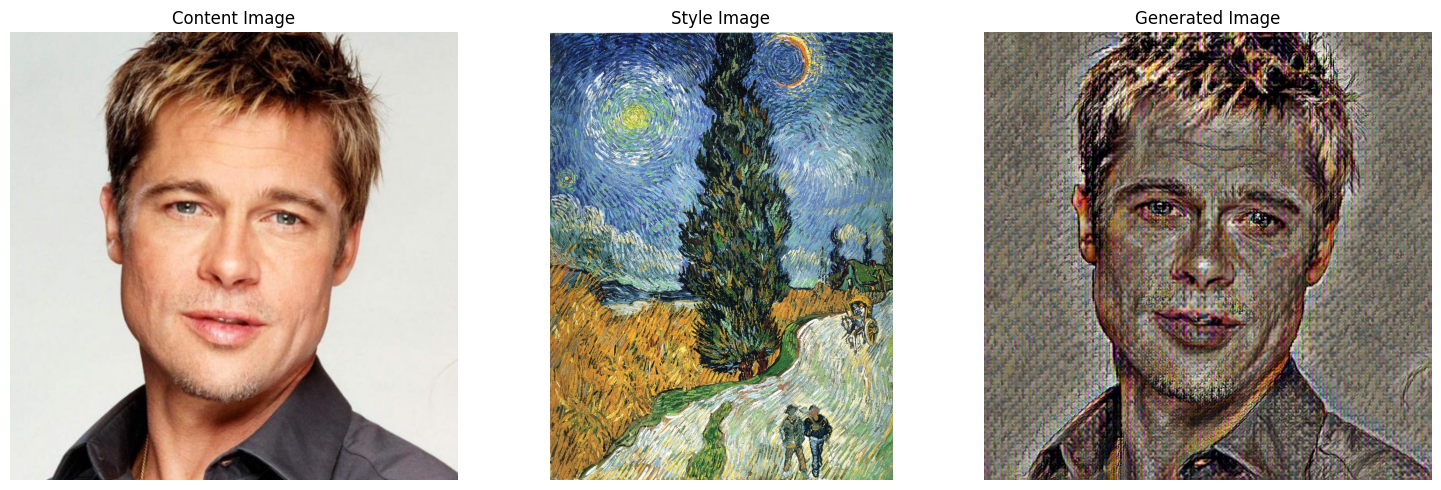

In [15]:
# TEST TRAINED MODEL HERE

content_path='test_data/brad_pitt.jpg'
style_path='test_data/vg.jpg'
model='model/model.pth'
alpha=1.0
device = get_device()
adain_model = load_saved_model(model, device)

# Transfer style
transfer_style(
    model=adain_model,
    content_path=content_path,
    style_path=style_path,
    device=device,
    alpha=alpha,
    show_plot=True
)